In [1]:
%matplotlib inline
from utils import *
from sklearn.model_selection import train_test_split
import pickle
from icnet import build_bn
import matplotlib.pyplot as plt

PATH = "C:\\Users\jgolb\Desktop\datasets\\"
image_size = (128, 128)

NET = 'unet'


Using TensorFlow backend.


In [2]:
SegClass = SegModel(PATH, image_size, use_coords = False)
SegClass.set_batch_size(8)
SegClass.set_num_epochs(2)
opt = RMSprop()

model = SegClass.create_seg_model(opt, net=NET, load_weights = False, 
                                  multi_gpu = False, to_compile = True, alpha = 1)
#model.summary()

In [3]:
model.load_weights('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5')

In [3]:
train_generator = SegClass.create_generators(resize_shape = image_size,
                                             crop_shape = False, mode = 'train',n_classes = 21, 
                                             horizontal_flip = True, vertical_flip = False, 
                                             icnet = NET == 'icnet',brightness=0.1, rotation=2.0, 
                                             zoom=0.1, validation_split = .2, seed = 7)

valid_generator = SegClass.create_generators(resize_shape = image_size,
                                             crop_shape = False, mode = 'validation', n_classes = 21, 
                                             horizontal_flip = True, vertical_flip = False, 
                                             icnet = NET == 'icnet',brightness=False, rotation=False, 
                                             zoom=0, validation_split = .01, seed = 7)

Epoch 1/2
15/15 [==============================] - 55s 4s/step - loss: 2.9056 - Mean_IOU: 0.1248 - background_accuracy: 0.0327 - accuracy_ignoring_last_label: 0.1213 - foreground_accuracy: 0.2989 - val_loss: 11.5219 - val_Mean_IOU: 0.0142 - val_background_accuracy: 0.0127 - val_accuracy_ignoring_last_label: 0.0195 - val_foreground_accuracy: 0.0327

Epoch 00001: val_Mean_IOU improved from -inf to 0.01425, saving model to weights/001_unet_128.h5
Epoch 2/2
15/15 [==============================] - 55s 4s/step - loss: 2.4071 - Mean_IOU: 0.1728 - background_accuracy: 0.0625 - accuracy_ignoring_last_label: 0.1543 - foreground_accuracy: 0.2928 - val_loss: 6.4989 - val_Mean_IOU: 0.0584 - val_background_accuracy: 0.0066 - val_accuracy_ignoring_last_label: 0.0403 - val_foreground_accuracy: 0.1203

Epoch 00002: val_Mean_IOU improved from 0.01425 to 0.05843, saving model to weights/002_unet_128.h5


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\jgolb\\Desktop\\datasets\\pred_masks/image_0'

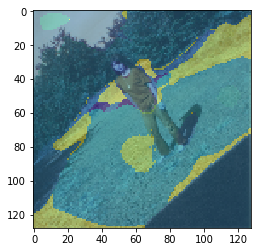

In [4]:
h, cyclr = SegClass.train_generator(model, train_generator=valid_generator,
                                    valid_generator = valid_generator, plot_test_images = True,
                                    tf_board = True, mp = False)

In [4]:
x,y,s = next(train_generator)

In [5]:
pred = model.predict(x)

In [46]:
y_pred = tf.convert_to_tensor(pred)
y_true = tf.convert_to_tensor(y)

In [2]:
# build model
SegClass = SegModel(PATH, image_size, use_coords = False)
SegClass.set_batch_size(4)
SegClass.set_num_epochs(1)

#opt = SGD(momentum=0.9, decay=0.0005)
#opt = Adam(lr=1e-3, decay=0.995)
opt = RMSprop()
# tiramisu, segnet, unet, deeplab, mobileunet, enet

model = SegClass.create_seg_model(opt, net='mobileunet', load_weights = False, 
                                  multi_gpu = False, to_compile = True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv_0_bn (BatchNormalization)  (None, 112, 112, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
conv_0_relu (Activation)        (None, 112, 112, 32) 0           conv_0_bn[0][0]                  
__________________________________________________________________________________________________
conv_dw_1 

In [3]:
train_generator = SegClass.create_generators(data_trn_gen_args_image, data_trn_gen_args_mask, 
                                             subset = 'training', target_size = (512,512))
valid_generator = SegClass.create_generators(data_val_gen_args_image, data_val_gen_args_mask, 
                                             subset = 'validation', target_size = (512,512))

Found 10827 images belonging to 1 classes.
Found 10827 images belonging to 1 classes.
Found 1202 images belonging to 1 classes.
Found 1202 images belonging to 1 classes.


In [4]:
#data_trn_gen_args_image['preprocessing_function'] = None
#plt.imshow(np.reshape(np.argmax(y[0], axis=-1), image_size))
#show_aug_data(train_generator, data_trn_gen_args_image, data_trn_gen_args_mask)

In [4]:
h, cyclr = SegClass.train_generator(model, train_generator=train_generator,
                                    valid_generator = valid_generator,
                                    tf_board = False, mp = False)

Epoch 1/1
2706/2706 [==============================] - 2199s 813ms/step - loss: 2.3318 - Mean_IOU: 0.1321 - background_sparse_accuracy: 0.4683 - sparse_accuracy_ignoring_last_label: 0.4683 - foreground_sparse_accuracy: 0.6560 - val_loss: 2.2638 - val_Mean_IOU: 0.1811 - val_background_sparse_accuracy: 0.5738 - val_sparse_accuracy_ignoring_last_label: 0.5738 - val_foreground_sparse_accuracy: nan

Epoch 00001: val_loss improved from inf to 2.26385, saving model to weights/mobileunet.h5


In [5]:
x,y,z = next(valid_generator)
preds = np.argmax(model.predict(x), axis=-1)

In [6]:
p = np.reshape(preds, (4,224,224))
p.shape

(4, 224, 224)

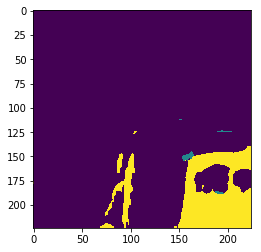

In [8]:
plt.imshow(p[3])

In [9]:
models_dir = './weights/'
model_filename = 'pc_big.pb'
convert_keras_to_pb(model, models_dir, model_filename)

INFO:tensorflow:Restoring parameters from ./saved_ckpt-0
INFO:tensorflow:Froze 190 variables.
INFO:tensorflow:Converted 190 variables to const ops.


In [10]:
[out.op.name for out in model.outputs]

['activation_1/truediv']

In [42]:
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, "weights", "pc2.pb", as_text=False)


INFO:tensorflow:Froze 456 variables.
INFO:tensorflow:Converted 456 variables to const ops.


'weights\\pc2.pb'

In [39]:
[out.op.name for out in model.outputs]

['activation_1/truediv']

Epoch 1/3
9000/9000 [==============================] - 38s 4ms/step - loss: 0.6978 - acc: 0.5032
Epoch 2/3
9000/9000 [==============================] - 37s 4ms/step - loss: 0.6940 - acc: 0.5158
Epoch 3/3
9000/9000 [==============================] - 37s 4ms/step - loss: 0.6938 - acc: 0.5120


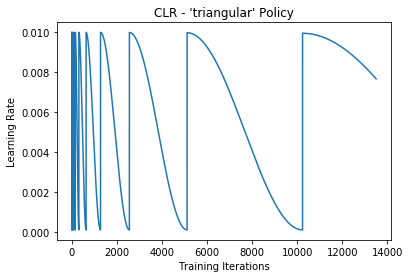

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input

inp = Input(shape=(15,))                
x = Dense(10, activation='relu')(inp)
x = Dense(1, activation='sigmoid')(x)

model = Model(inp, x)
X = np.random.rand(9000,15)
Y = np.random.randint(0,2,size=9000)
clr_triangular = CyclicLR(base_lr=0.0001, max_lr=0.01,
                      step_size=5, mode = 'cosine', gamma = 0.9999995,
                      scale_mode='iterations', cycle_mult = 2)

model.compile(optimizer=SGD(0.1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, Y, batch_size=2, nb_epoch=3, callbacks=[clr_triangular], verbose=1)
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])


### Freezing model

In [ ]:
#models_dir = './models/'
#model_filename = 'model_tf_{}x{}.pb'.format(image_size[0], image_size[1])
#convert_keras_to_pb(deeplab_model, models_dir, model_filename)


In [5]:
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in deeplab_model.outputs])
tf.train.write_graph(frozen_graph, "weights", "stack128.pb", as_text=False)


INFO:tensorflow:Froze 492 variables.
INFO:tensorflow:Converted 492 variables to const ops.


'weights\\stack128.pb'

#### Create Generators

In [ ]:
data_trn_gen_args_mask = dict(preprocessing_function = preprocess_mask,
                              horizontal_flip=True, rotation_range=45,
                              width_shift_range=0.01, 
                              height_shift_range=0.01,
                              zoom_range=0.2, 
                              validation_split = .2,
                              )

data_trn_gen_args_image = dict(preprocessing_function = preprocess_input,
                               horizontal_flip=True, rotation_range=45,
                               width_shift_range=0.01, 
                               height_shift_range=0.01,
                               zoom_range=0.2, 
                               validation_split = .2,
                               channel_shift_range = .2
                               )

data_val_gen_args_image = dict(preprocessing_function = preprocess_input, validation_split = .2)
data_val_gen_args_mask = dict(validation_split = .2)

train_generator = deeplab_seg.create_generators(data_trn_gen_args_image, data_trn_gen_args_mask, subset = 'training')
valid_generator = deeplab_seg.create_generators(data_val_gen_args_image, data_val_gen_args_mask, subset = 'validation')

In [ ]:
data_trn_gen_args_image['preprocessing_function'] = None

show_aug_data(train_generator, data_trn_gen_args_image, data_trn_gen_args_mask)

## Train Model

In [ ]:
h = deeplab_seg.train_generator(deeplab_model, train_generator=train_generator, 
                                valid_generator = valid_generator, 
                                tf_board = True, mp = True)

### EVALUATION

In [ ]:
classes = [c for c in get_VOC2012_classes().values()]
y_preds = deeplab_model.predict(X_test, batch_size = deeplab_seg.batch_size, verbose=1)
df_test, conf_test, mean_acc_test = evaluate_model(y_preds, y_test, data_from = 'test')

y_preds = deeplab_model.predict(X_valid, batch_size = deeplab_seg.batch_size, verbose=1)
df_valid, conf_valid, mean_acc_valid = evaluate_model(y_preds, y_valid, data_from = 'valid')
df_test['IoU valid'] = df_valid['IoU valid']

if deeplab_seg.coords:
    model_name = 'deeplabv3+ with added coordconv channels'
else:
    model_name = 'deeplabv3+'

plt.figure(figsize=(17,7))
plt.subplot(121)
plot_confusion_matrix(conf_test, classes, normalize=True, 
                      title='Pixel-wise confusion matrix of Test set. Model: '+model_name)
plt.subplot(122)
plot_confusion_matrix(conf_valid, classes, normalize=True, 
                      title='Pixel-wise confusion matrix of Validation set. Model: '+model_name)

print('test mean acc: ', mean_acc_test)
print('validation mean acc: ', mean_acc_valid)
df_test